In [1]:
import paths
import yaml
import os
import copy
import h5py
import GPy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm, ticker, colors
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
from cklemap.sdfs.darcy import DarcyExp
from cklemap.sdfs.dasa import DASAExpLM, DASAExpLMAMPS
import cklemap.ckli.mapest as mapest

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
amps = True
res_fac = 1
resolution = '1x'
resolution_iYobs = '4x'
num_trials = 10
seed = 0
#Nuobs = 50
NYobs = 25
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
beta_ckli = 1e1
Ygamma_ckli = 1e-4
ugamma_ckli = 1e-4
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
Neumann_sd = 0
lsq_method = 'trf'
run_PICKLE = False
data_path = '../data/'
results_path = '../results/'
figures_path = '../figures/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
geom_fine_filename = data_path + f'geom/geom_{resolution_iYobs}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'RF1/conduct_log_RF1_{resolution}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution_iYobs}.npy'
ref = "Yref=RF1"

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

with h5py.File(conduct_filename, 'r') as f:
    Yref = f.get('conduct_log')[:].ravel() - Yfac

In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1

prob = DarcyExp(TPFA(geom, bc), iuobs, amps)
uref = prob.solve(Yref)
uobs = uref[iuobs]
Nuobs = iuobs.size

In [7]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref + Yfac, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [8]:
if os.path.exists(yobs_filename):
    print(f"iYobs read from file {yobs_filename}")
    iYobs_fine = np.load(yobs_filename)
    print(iYobs_fine.shape)
    geom_fine = GeomMRST(geom_fine_filename)
    iYobs = np.array([geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)])
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs read from file ../data/yobs/yobs_25_4x.npy
(10, 25)
iYobs.shape=(10, 25)
[[ 231  326  361  362  420  446  458  487  558  651  674  758  761  838
   853  857  884  897  900 1031 1114 1157 1338 1444 1465]
 [  22  146  183  248  302  311  436  454  495  533  600  615  673  695
   806  841  933 1005 1009 1038 1086 1225 1242 1323 1364]
 [  90   96  116  152  158  159  269  328  339  392  401  530  541  571
   650  809  941  981 1035 1099 1158 1165 1194 1304 1444]
 [ 107  112  164  170  290  332  337  405  547  557  569  592  620  676
   698  706  882  967  982 1081 1130 1261 1287 1323 1395]
 [  43   55  200  274  323  338  376  379  563  572  651  721  797 1026
  1067 1074 1143 1234 1241 1375 1410 1435 1453 1457 1467]
 [  23  204  221  227  250  549  575  577  595  764  817  839  855  870
  1016 1148 1256 1284 1288 1290 1291 1314 1349 1393 1414]
 [  52  100  118  218  486  499  615  648  784  822  824  849  853  973
   975 1054 1107 1114 1129 1156 1309 1368 1395 1421 1430]
 [  86  112

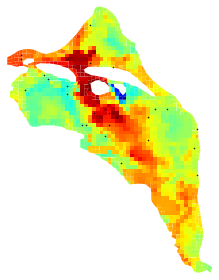

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_patch(patches, Yref + Yfac, fig, ax, geom.cells.centroids[:, iYobs[0]], 'Yref', 0, 12)
fig.tight_layout()
fig.savefig(figures_path + f'Yref/Yref_NY={NYobs}_1x_from_4x.pdf', dpi=300)

In [10]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_gamma={gamma_map}_{lsq_method=}_h1reg_{amps=}_{ref}'
print(exp)

timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))
solve_time = np.zeros((num_trials))
obj_time = np.zeros((num_trials))
jac_time = np.zeros((num_trials))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
umean = np.zeros((num_trials, Nc))
Cu = np.zeros((num_trials, Nc, Nc))
upred = np.zeros((num_trials, Nc))
Cupred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))
Psiu = np.zeros((num_trials, Nc, Nuxi))
Lambdau = np.zeros((num_trials, Nuxi))

uxi = np.zeros((num_trials, Nuxi))
Yxi = np.zeros((num_trials, NYxi))
uest = np.zeros((num_trials, Nc))
Yest = np.zeros((num_trials, Nc))
Yest_MAPH1 = np.zeros((num_trials, Nc))
if Neumann_sd != 0:
    Nq = np.count_nonzero(bc.kind == 'N')
    q_MAPH1 = np.zeros((num_trials, Nq))

NY=25_Nu=323_NYlearn=25_gamma=1e-06_lsq_method='trf'_h1reg_amps=True_Yref=RF1


In [11]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    print(f'{klearn.lengthscale.values[0]}')

    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   4.697858e+01   8.459767e+01 
    00s02  0009   4.068870e+01   1.890054e-01 
    00s04  0016   4.067551e+01   2.902244e-11 
Runtime:     00s04
Optimization status: Converged

0.06195897884051012
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   1.950715e+02   4.565181e+05 
    00s02  0010   3.513658e+01   7.220024e-02 
    00s03  0016   3.511860e+01   1.068422e-10 
Runtime:     00s03
Optimization status: Converged

0.10358843339830524
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0007   4.055971e+01   6.715844e-01 
    00s03  0013   4.041663e+01   1.178537e-10 
Runtime:     00s03
Optimization status: Converged

0.055248312017132595
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   4.948958e+01   1.896190e

In [12]:
if run_PICKLE:
    for t in range(num_trials):
        ts = perf_counter()
        umean[t], Cu[t] = ckliest.smc_gp(Ypred[t], CYpred[t], Nens, copy.deepcopy(prob), rs, randomize_bc=True, randomize_scale=Neumann_sd)
        upred[t], Cupred[t] = ckliest.gpr(umean[t], Cu[t], uobs, iuobs)
        timings[t, 1] = perf_counter() - ts

    print(f"Monte Carlo: {timings[:, 1]} s")

In [13]:
if run_PICKLE:
    Ym = Ypred
    CYm = CYpred
    um = umean #or change to upred
    Cum = Cu #or change to Cupred

    rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
    abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

    print(f"GPR\tRelative error: {rel_errors[:, 0]}")
    print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

In [14]:
if run_PICKLE:
    for t in range(num_trials):
        ts = perf_counter()
        PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
        Psiu[t], Lambdau[t] = ckliest.KL_via_eigh(Cum[t], Nuxi)
        timings[t, 2] = perf_counter() - ts

    print(f"eigendecomposition: {timings[:, 2]} s")

In [15]:
# PICKLE estimate
ssv = None if Neumann_sd == 0 else np.delete(np.arange(Nc), np.unique(geom.cells.to_hf[2*geom.faces.num_interior:][bc.kind == 'N']))
Lreg = mapest.compute_Lreg(geom)

if run_PICKLE:
    for t in range(num_trials):
        res = ckliest.LeastSqRes(NYxi, Ym[t], PsiY[t], Nuxi, um[t], Psiu[t], prob, ugamma_ckli, Ygamma_ckli, res_fac, Lreg, iuobs, uobs, iYobs[t], Yobs[t], beta_ckli, ssv=ssv)

        ts = perf_counter()
        sol = spo.least_squares(res.val, np.zeros(Nuxi + NYxi), jac=res.jac, method=lsq_method, verbose=2)
        ckli_status = sol.status
        timings[t, 3] = perf_counter() - ts
        nfevs[t, 0] = sol.nfev
        print(f'CKLI optimality: {sol.optimality : g}')

        uxi[t] = sol.x[:Nuxi]
        Yxi[t] = sol.x[Nuxi:]
        uest[t] = um[t] + Psiu[t] @ uxi[t]
        Yest[t] = Ym[t] + PsiY[t] @ Yxi[t]

    rel_errors[:, 1] = np.array([rl2e(Yest[t], Yref) for t in range(num_trials)])
    abs_errors[:, 1] = np.array([infe(Yest[t], Yref) for t in range(num_trials)])

    print(f"PICKLE: {timings[:, 3]} s")
    print(f"PICKLE\trelative L2 error: {rel_errors[:, 1]}")
    print(f"PICKLE\tabsolute infinity error: {abs_errors[:, 1]}")

In [16]:
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    # MAP H1 estimate
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpLMAMPS(prob.partial_solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, prob.u_sens_p, (Nuobs + NYobs + Ninf, Nc), Nuobs)
    else:
        dasa = DASAExpLM(prob.solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, (Nuobs + NYobs + Ninf, Nc), Nuobs)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(Nc), jac=dasa.grad, method=lsq_method, verbose=2)
    timings[t, 4] = perf_counter() - ts
    Yest_MAPH1[t] = sol.x
    nfevs[t, 1] = sol.nfev

    MAP_status = sol.status
    print(f'MAP status: {MAP_status}, message: {sol.message}')
    
    solve_time[t] = dasa.solve_time
    obj_time[t] = dasa.obj_time
    jac_time[t] = dasa.jac_time

rel_errors[:, 2] = np.array([rl2e(Yest_MAPH1[t], Yref) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest_MAPH1[t], Yref) for t in range(num_trials)])

print(f"MAP: {timings[:, 4]} s")
print(f"MAP\trelative L2 error: {rel_errors[:, 2]}")
print(f"MAP\tabsolute infinity error: {abs_errors[:, 2]}")
print(f"MAP solve time: {solve_time}")
print(f"MAP objective time: {obj_time}")
print(f"MAP Jacobian time: {jac_time}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.3224e+02                                    5.84e+01    
       1              2         5.2351e+02      1.09e+02       1.00e+00       4.92e+01    
       2              3         3.4639e+02      1.77e+02       2.00e+00       2.86e+01    
       3              4         1.5738e+02      1.89e+02       4.00e+00       6.00e+00    
       4              5         5.5076e+01      1.02e+02       8.00e+00       1.65e+00    
       5              6         1.2679e+01      4.24e+01       1.60e+01       4.62e+00    
       6              7         2.0614e+00      1.06e+01       3.20e+01       1.59e+00    
       7              8         5.1161e-01      1.55e+00       2.65e+01       4.72e-01    
       8              9         1.2025e-01      3.91e-01       1.24e+01       2.80e-01    
       9             10         4.0104e-02      8.01e-02       8.45e+00       2.40e-01    

In [17]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YPICKLE/YPICKLE_{exp}.txt', Yest)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest_MAPH1)

In [18]:
if run_PICKLE:
    fig, ax = plt.subplots(figsize=(4, 4))

    plot_patch(patches, Yest[0, :] + Yfac, fig, ax, geom.cells.centroids[:, iYobs[0]], 'Yest (PICKLE)', 0, 12)

    fig.tight_layout()
    fig.savefig(figures_path + f'YPICKLE/YPICKLE_{exp}.pdf', dpi=300)

In [19]:
if run_PICKLE:
    fig, ax = plt.subplots(figsize=(4, 4))

    plot_patch(patches, np.abs(Yest[0, :] - Yref), fig, ax, geom.cells.centroids[:, iYobs], 'Ydiff (PICKLE)', 0, 7)

    fig.tight_layout()
    fig.savefig(figures_path + f'Ydiff_PICKLE/Ydiff_PICKLE_{exp}.pdf', dpi=300)

In [20]:
t=0

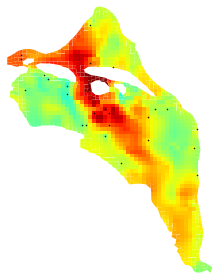

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, Yest_MAPH1[t, :] + Yfac, fig, ax, geom.cells.centroids[:, iYobs[t]], 'Yest (MAP)', 0, 12)

fig.tight_layout()
fig.savefig(figures_path + f'YMAP/YMAP_{exp}.pdf', dpi=300)

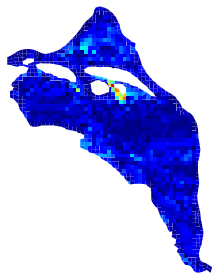

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, np.abs(Yest_MAPH1[t, :] - Yref), fig, ax, geom.cells.centroids[:, iYobs[t]], 'Ydiff (MAP)', 0, 7)

fig.tight_layout()
fig.savefig(figures_path + f'Ydiff_MAP/Ydiff_MAP_{exp}.pdf', dpi=300)